In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Open CSV file as ***'df_answers'***  DataFrame

In [2]:
df = pd.read_csv('cleaned_df.csv', index_col = False)

### Info about our new dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30746 entries, 0 to 30745
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Professional        30746 non-null  object 
 1   ProgramHobby        30746 non-null  object 
 2   Country             30746 non-null  object 
 3   University          30746 non-null  object 
 4   EmploymentStatus    30746 non-null  object 
 5   FormalEducation     30746 non-null  object 
 6   MajorUndergrad      30746 non-null  object 
 7   HomeRemote          30746 non-null  object 
 8   CompanySize         30746 non-null  object 
 9   CompanyType         30746 non-null  object 
 10  YearsProgram        30746 non-null  object 
 11  YearsCodedJob       30746 non-null  object 
 12  CareerSatisfaction  30746 non-null  float64
 13  JobSatisfaction     30746 non-null  float64
 14  Gender              30746 non-null  object 
 15  Race                30746 non-null  object 
 16  Deve

***

## Target (y) column inspection

In [4]:
df['Salary'].describe().round(2)

count     10353.00
mean      65105.80
std       43458.32
min           0.00
25%       33009.75
50%       57000.00
75%       91774.51
max      248555.95
Name: Salary, dtype: float64

In [5]:
df_salary = df['Salary']

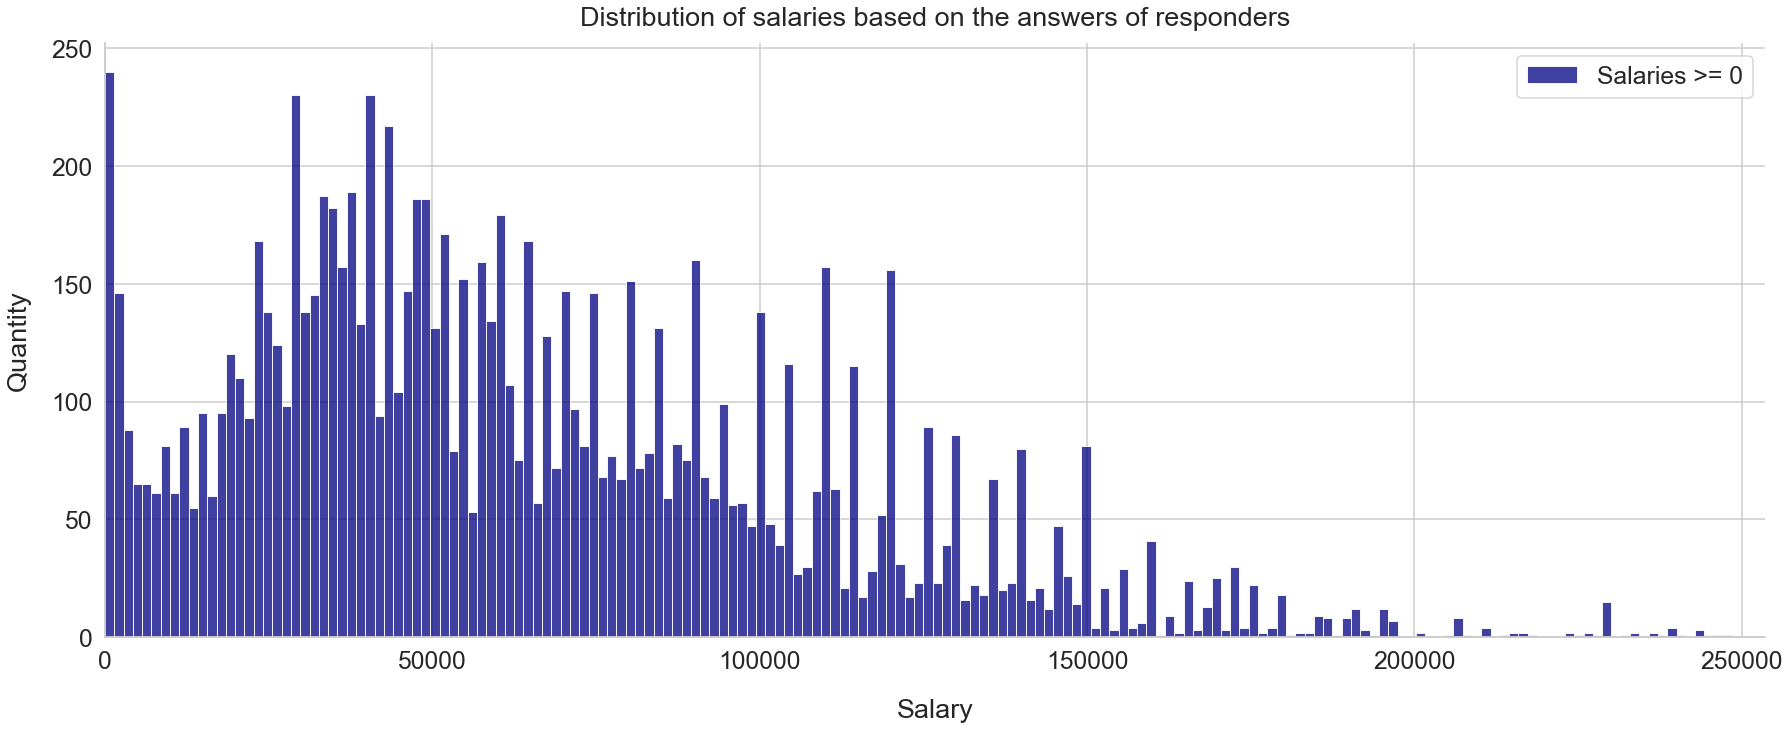

In [6]:
bin_size = np.sqrt(len(df_salary)).astype('int')

sns.set(context="talk", font_scale=1.5, style="whitegrid")

sns.displot(data=df, x='Salary', kind='hist', bins=bin_size, rug_kws=1,
            height=10, aspect=2.5, color='navy', label='Salaries >= 0')
plt.legend()
plt.xlabel('Salary', labelpad=25)
plt.ylabel('Quantity', labelpad=20)
plt.xlim((df_salary.min(), df_salary.max() * 1.02))
plt.title('Distribution of salaries based on the answers of responders', y=1.02)

plt.show()

In [7]:
from scipy import stats
from sklearn.preprocessing import quantile_transform, QuantileTransformer

func_names = ['Original data', 'Yeojohnson', 'Sqrt', 'Quantile transform']

def data_transform(orig_data, col_name):
    _ = pd.DataFrame(columns=col_name)
    _[col_name[0]] = orig_data
    _[col_name[1]] = stats.yeojohnson(orig_data)[0].reshape(len(orig_data), 1)
    _[col_name[2]] = np.sqrt(orig_data)
    _[col_name[3]] = QuantileTransformer(subsample=len(orig_data), output_distribution='normal',
                                         n_quantiles=len(orig_data)).fit_transform(orig_data.values.reshape(-1, 1))
    return _

df_salary_transformed = data_transform(df_salary, func_names)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


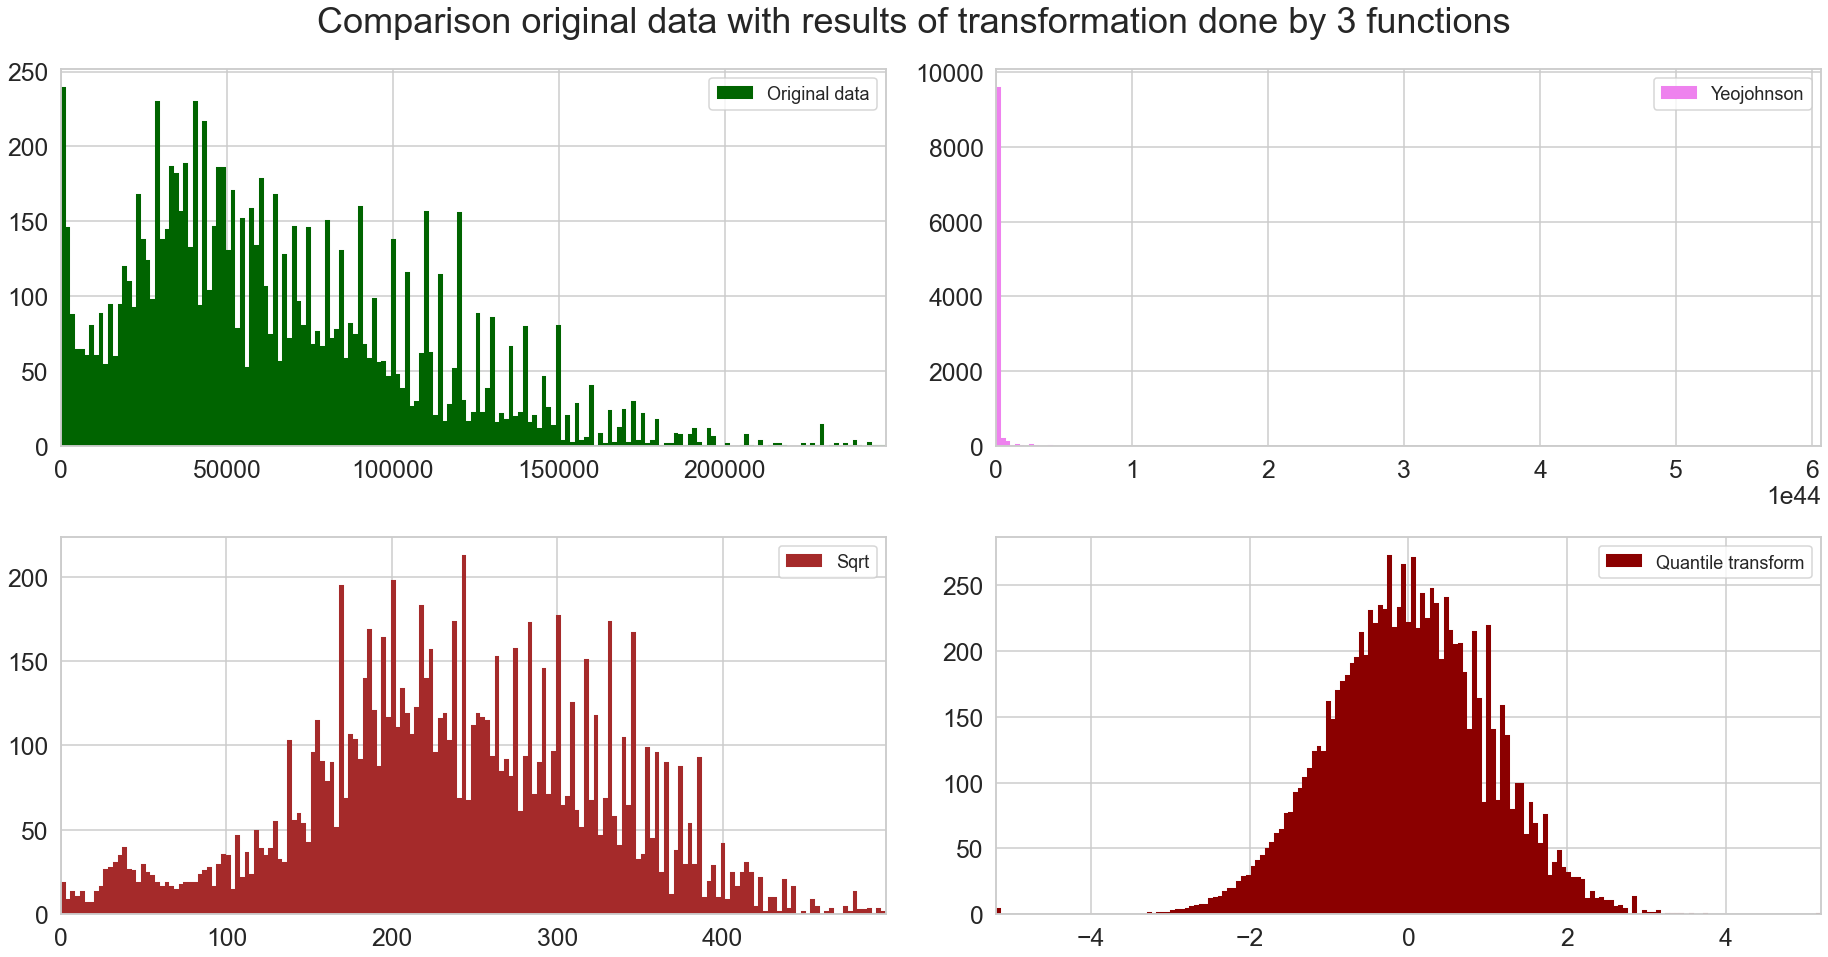

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(26, 14))

axs = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]
colors_list = ['darkgreen', 'violet', 'brown', 'darkred']

## 
for inputs, colors, axes in zip(func_names, colors_list, axs):
    df_salary_transformed[inputs].plot.hist(bins = bin_size, color = colors, edgecolor = colors, 
                                            linewidth=0.05, label = inputs, ax = axes)
    axes.set_xlabel(xlabel=None)
    axes.set_ylabel(ylabel=None)
    axes.set_xlim((df_salary_transformed[inputs].min(), df_salary_transformed[inputs].max()))
    axes.legend(fontsize = 18)    

plt.suptitle('Comparison original data with results of transformation done by 3 functions', 
             fontsize = 36, y=0.965)
plt.tight_layout()
plt.show()

In [9]:
# Basic stats for above 4 functions:
df_salary_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
Original data,10353.0,6.510580e+04,4.345832e+04,0.000000,3.300975e+04,5.700000e+04,9.177451e+04,2.485560e+05
Yeojohnson,10353.0,2.984493e+42,2.459520e+43,0.000000,2.262920e+37,2.314671e+39,1.308888e+41,6.064405e+44
Sqrt,10353.0,2.385003e+02,9.068732e+01,0.000000,1.816859e+02,2.387467e+02,3.029431e+02,4.985539e+02
Quantile transform,10353.0,-6.693520e-04,1.004531e+00,-5.199338,-6.735944e-01,-1.100650e-03,6.741571e-01,5.199338e+00


---

## Importing libraries which are necessary for properly work the rest of the prediction task.

In [10]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from shutil import rmtree
import joblib
from sklearnex import patch_sklearn
patch_sklearn()

df_dropna = df.dropna(subset=['Salary']).reset_index(drop=True)
X, y = df_dropna.drop(['Salary'], axis=1), df_dropna['Salary']

X = X.astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

categorical_features = X.columns
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers = [('cat', categorical_transformer, categorical_features)])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [11]:
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import Lasso, PassiveAggressiveRegressor, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from xgboost.sklearn import XGBRegressor

### Before I start optimize each regressor, I will find the best features from data using 3 regressor based on different algorythm methods:
### 1) support vectors - LinearSVR,
### 2) trees - RandomForest,
### 3) linear model - Lasso.

In [12]:
def plot_best_features(df, regr_name, k):
	fig, ax = plt.subplots(1, 1, figsize=(26, 20))
	sns.barplot(x="value", y="feature", data=df.head(k), 
				orient='h', palette=df.head(k)["colors"])
	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
	ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
	ax.set_title(f"Top {k} Features for '{regr_name.__class__.__name__}'", fontsize=36, pad=25)
	ax.set_ylabel("Coef", fontsize=20)
	ax.set_xlabel("Feature Name", fontsize=20)
	plt.show()


def importance_features_checking(regr_name, *k):
	# define the model
	model = Pipeline(steps=[('preprocessor', preprocessor),
							('regr', regr_name)])
	# fit the model
	model.fit(X_train, y_train)

	# Get the names of each feature
	feature_names = model.named_steps["preprocessor"].get_feature_names_out()
	# Get the coefficients of each feature
	if regr_name.__class__.__name__ == 'RandomForestRegressor':
		coefs = model.named_steps["regr"].feature_importances_.flatten()
	else:
		coefs = model.named_steps["regr"].coef_.flatten()

	# Zip coefficients and names together and make a DataFrame
	zipped = zip(feature_names, coefs)
	df = pd.DataFrame(zipped, columns=["feature", "value"])

	# Sort the features by the absolute value of their coefficient
	df["abs_value"] = df["value"].apply(lambda x: abs(x))
	df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
	df = df.sort_values("abs_value", ascending=False)

	if k:
		plot_best_features(df, regr_name, k)

	return df


regr_list = [LinearSVR(max_iter=1e8), RandomForestRegressor(), Lasso(max_iter=1e8)]

def most_importance_features(regr_list, n):
    ind_list = []
    ## Indexes of the 'n' the most important features for list of regressors
    for i in regr_list:#
        ind_list += list(importance_features_checking(i)['feature'][:n].index)
    ## Return unique values from concatenated lists
    unique_ind = list(set(ind_list))
    print(f'Total number of features from all regressors={len(regr_list)*n} - unique values are {100*(len(unique_ind)/(len(regr_list)*n)):.0f}% of them')
    return unique_ind

all_importance_features_index = most_importance_features(regr_list, 50)

Total number of features from all regressors=150 - unique values are 69% of them


### Calculate `X_train_ohe` and `X_test_ohe` with unique features only using OneHotEncoder - both variables will be used to compare r2_score results using part and full dataset.

In [13]:
import scipy.sparse

def manual_features_encoding(X_train, y_train, X_test):
	# configure to select a subset of features
	ohe = OneHotEncoder(handle_unknown='ignore')
	# learn relationship from training data
	ohe.fit(X_train, y_train)
	# transform input data
	X_train_ohe, X_test_ohe = ohe.transform(X_train), ohe.transform(X_test)
	final_X_train, final_X_test = np.array(X_train_ohe.toarray())[:, all_importance_features_index], np.array(X_test_ohe.toarray())[:, all_importance_features_index]

	return final_X_train, final_X_test


X_train_ohe, X_test_ohe = manual_features_encoding(X_train, y_train, X_test)

In [14]:
def best_features_predictions_result(regr_list):
    print('Predition results calculated on only the best features in dataset:')
    for regr in regr_list:
        # prepare the model with target scaling
        model = TransformedTargetRegressor(regressor=regr, transformer=QuantileTransformer(output_distribution="normal"))
        model.fit(X_train_ohe, y_train)
        r2_score = model.score(X_test_ohe, y_test)
        print(f'\tFor "{regr.__class__.__name__}" regressor, R2={(100*r2_score):.1f}%')

def all_features_predictions_result(regr_list):
    print('\n\nPredition results calculated on all features in dataset:')
    for regr in regr_list:
        # prepare the model with target scaling
        model = TransformedTargetRegressor(regressor=regr, transformer=QuantileTransformer(output_distribution="normal"))
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
        pipe.fit(X_train, y_train)
        # evaluate the model
        yhat = pipe.predict(X_test)
        r2_score = pipe.score(X_test, y_test)
        print(f'\tFor "{regr.__class__.__name__}" regressor, R2={(100*r2_score):.1f}%')

best_features_predictions_result(regr_list)
all_features_predictions_result(regr_list)

Predition results calculated on only the best features in dataset:
	For "LinearSVR" regressor, R2=57.6%
	For "RandomForestRegressor" regressor, R2=49.6%
	For "Lasso" regressor, R2=-5.3%


Predition results calculated on all features in dataset:
	For "LinearSVR" regressor, R2=58.7%
	For "RandomForestRegressor" regressor, R2=52.7%
	For "Lasso" regressor, R2=-5.3%


## **Conclusion before start tuning regressors with hyperparameters:**
### - biggest different between R2 score for the same regressor is about 3% (RandomForest), but it is occupied by huge time consumption (results for all 3 regressors with partial dataset are ready after 1 second, for full dataset it is ~80 seconds)
### - disappointed result for Lasso regressor (score is negative no matter of which prediction functions were used!!)

---